In [6]:
import sys
import scanpy as sc
import pandas as pd

In [4]:
adata=sc.read_mtx_gpu("matrix.mtx")

In [13]:
adata.obs_names=pd.read_csv("barcodes.tsv",header=None)[0].values
adata.var_names=pd.read_csv("features.tsv",header=None)[0].values

In [14]:
import cudf
meta=cudf.read_csv("annot.csv",index_col=0).to_pandas()

In [15]:
meta.index.name=None

In [16]:
adata.obs=meta.loc[adata.obs_names,:]

In [17]:
import scanpy as sc

In [18]:
sc.pp.calculate_qc_metrics(adata,inplace=True,log1p=False,percent_top=None)

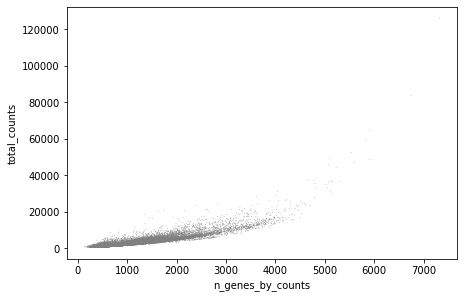

In [19]:
sc.pl.scatter(adata,x='n_genes_by_counts',y='total_counts')

In [20]:
selection=(adata.obs.n_genes_by_counts>100) & (adata.obs.n_genes_by_counts<4500) & (adata.obs.total_counts<2e5) 

In [21]:
adata=adata[selection]

In [22]:
adata.raw=adata

In [23]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

In [24]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger")

In [25]:
adata

AnnData object with n_obs × n_vars = 56592 × 17667
    obs: 'Cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'to.filter', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'Cluster', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [26]:
sc.pp.pca(adata)

sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

sc.tl.umap(adata,method="rapids")

/home/lfaure/miniconda3/envs/rapids-22.06/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


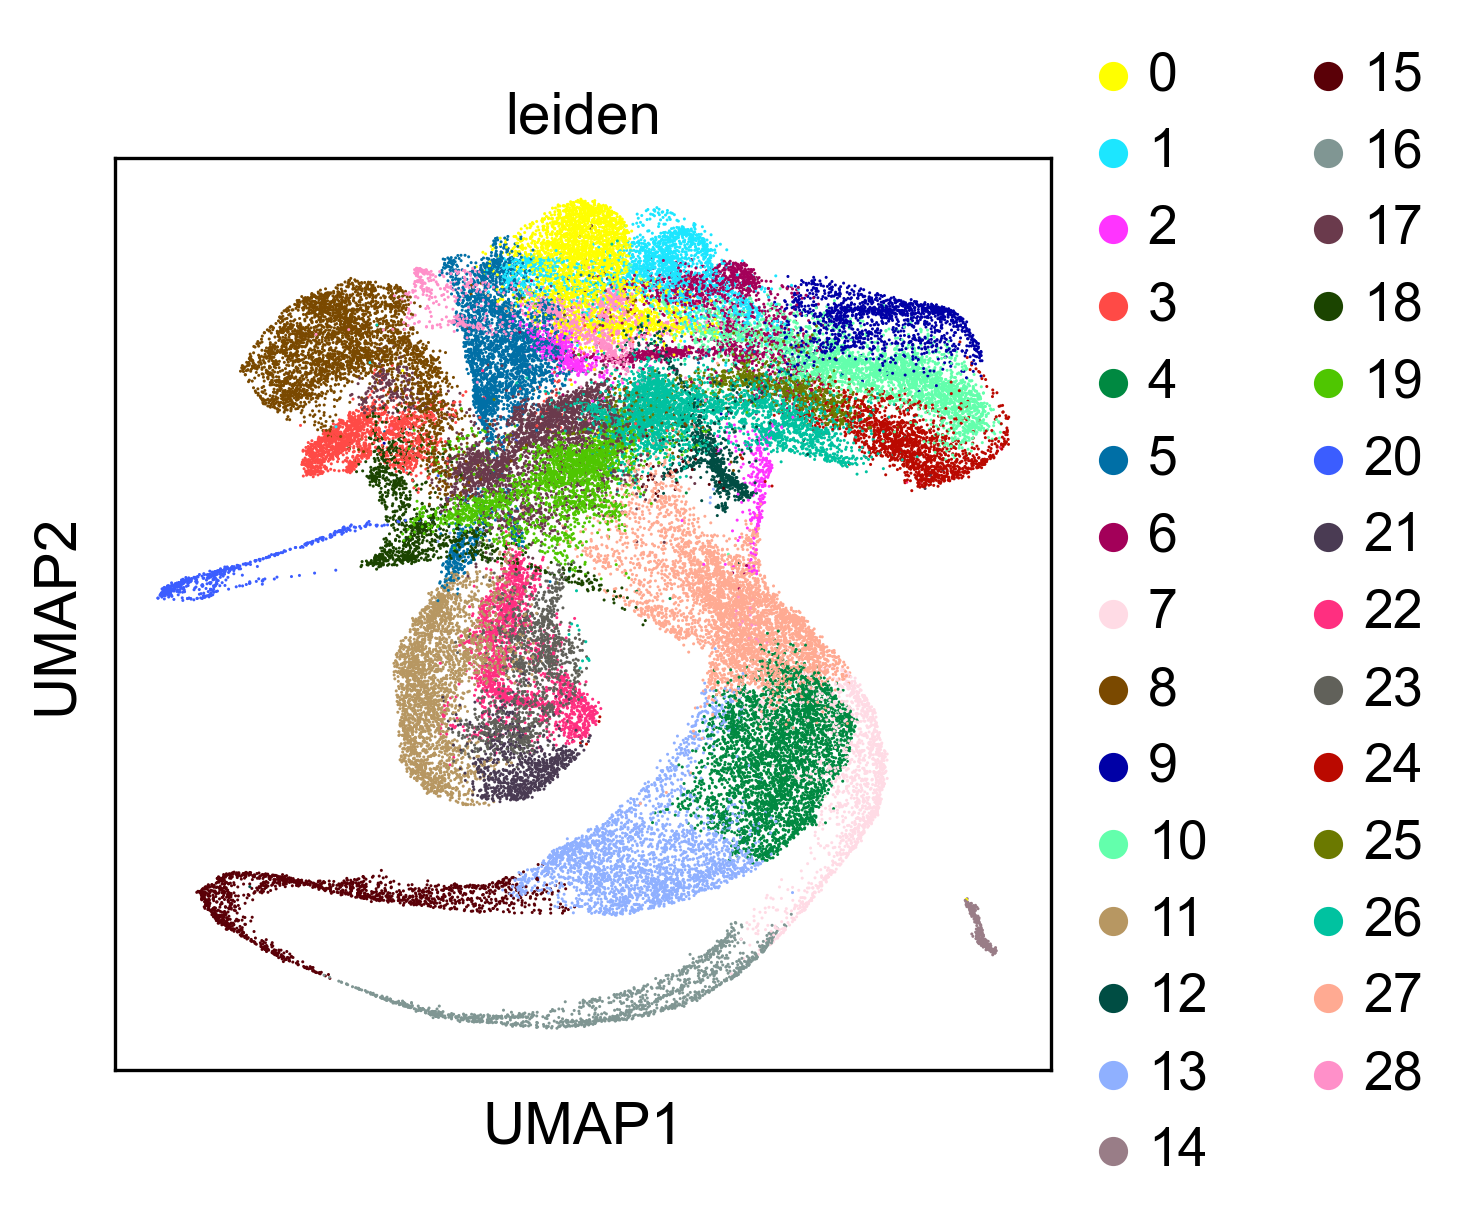

In [27]:
sc.tl.leiden(adata,flavor="rapids")

sc.set_figure_params(dpi=150)
sc.pl.umap(adata,color='leiden')

In [29]:
sc.tl.draw_graph(adata,method="rapids")

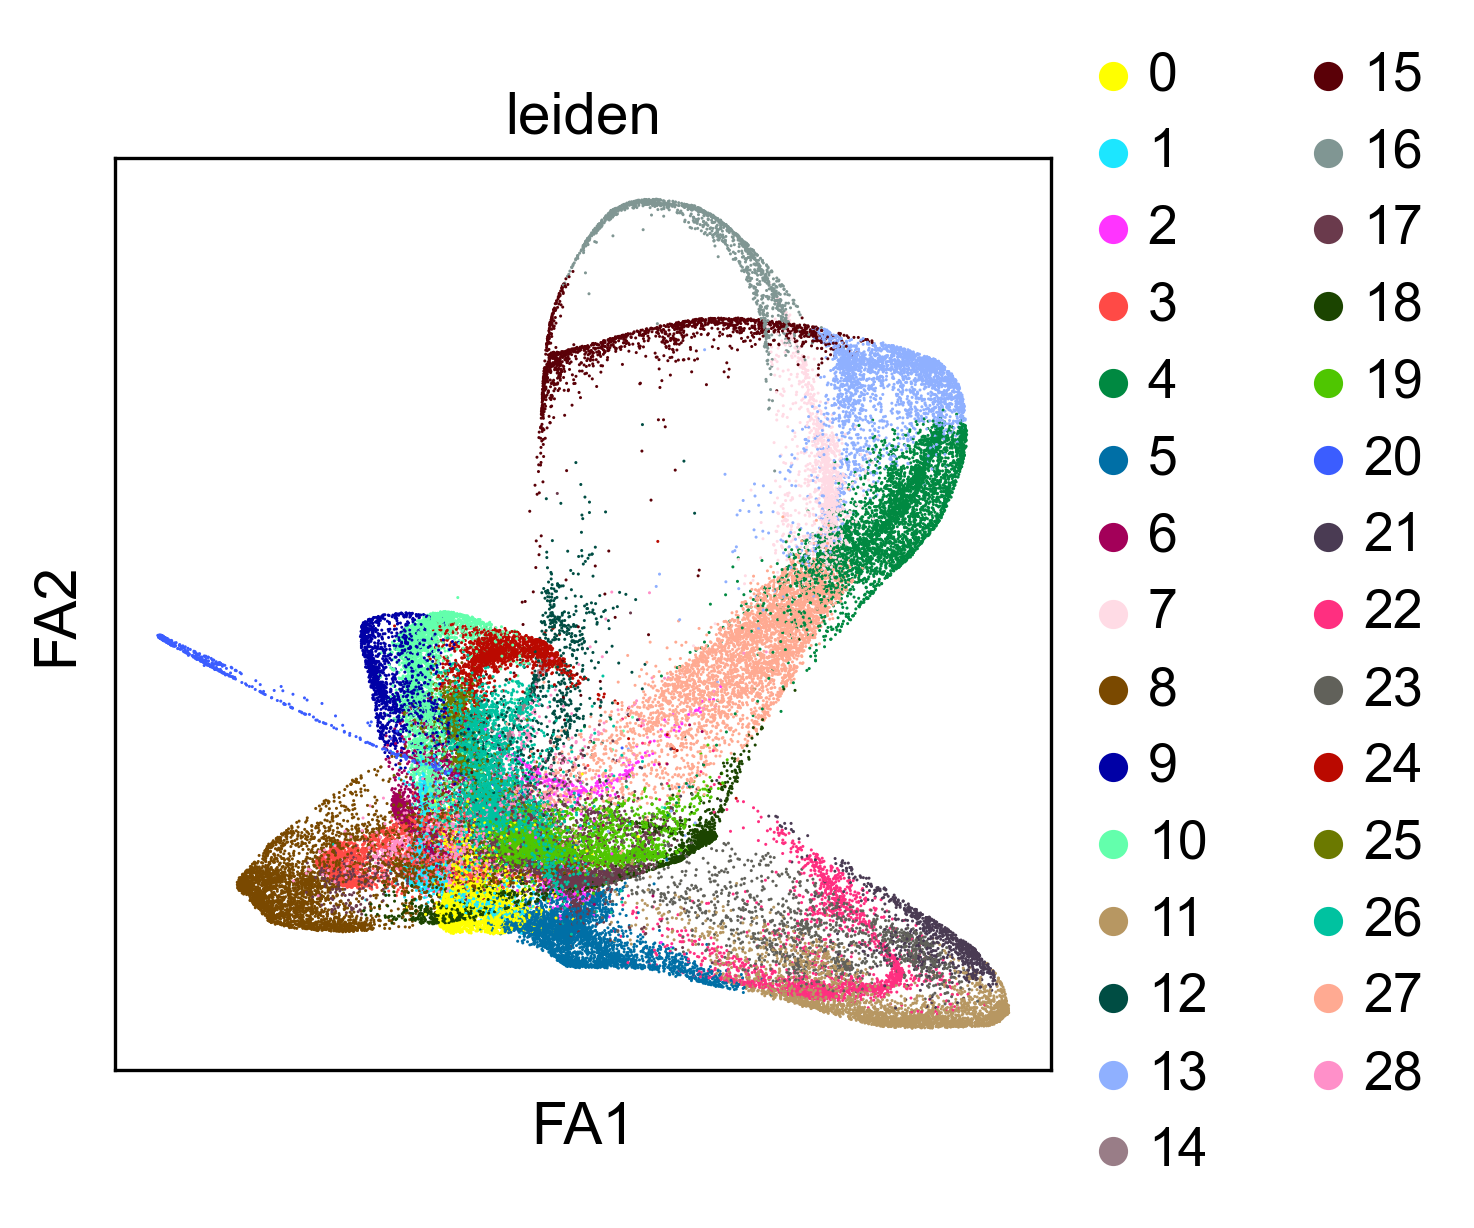

In [30]:
sc.pl.draw_graph(adata,color='leiden')

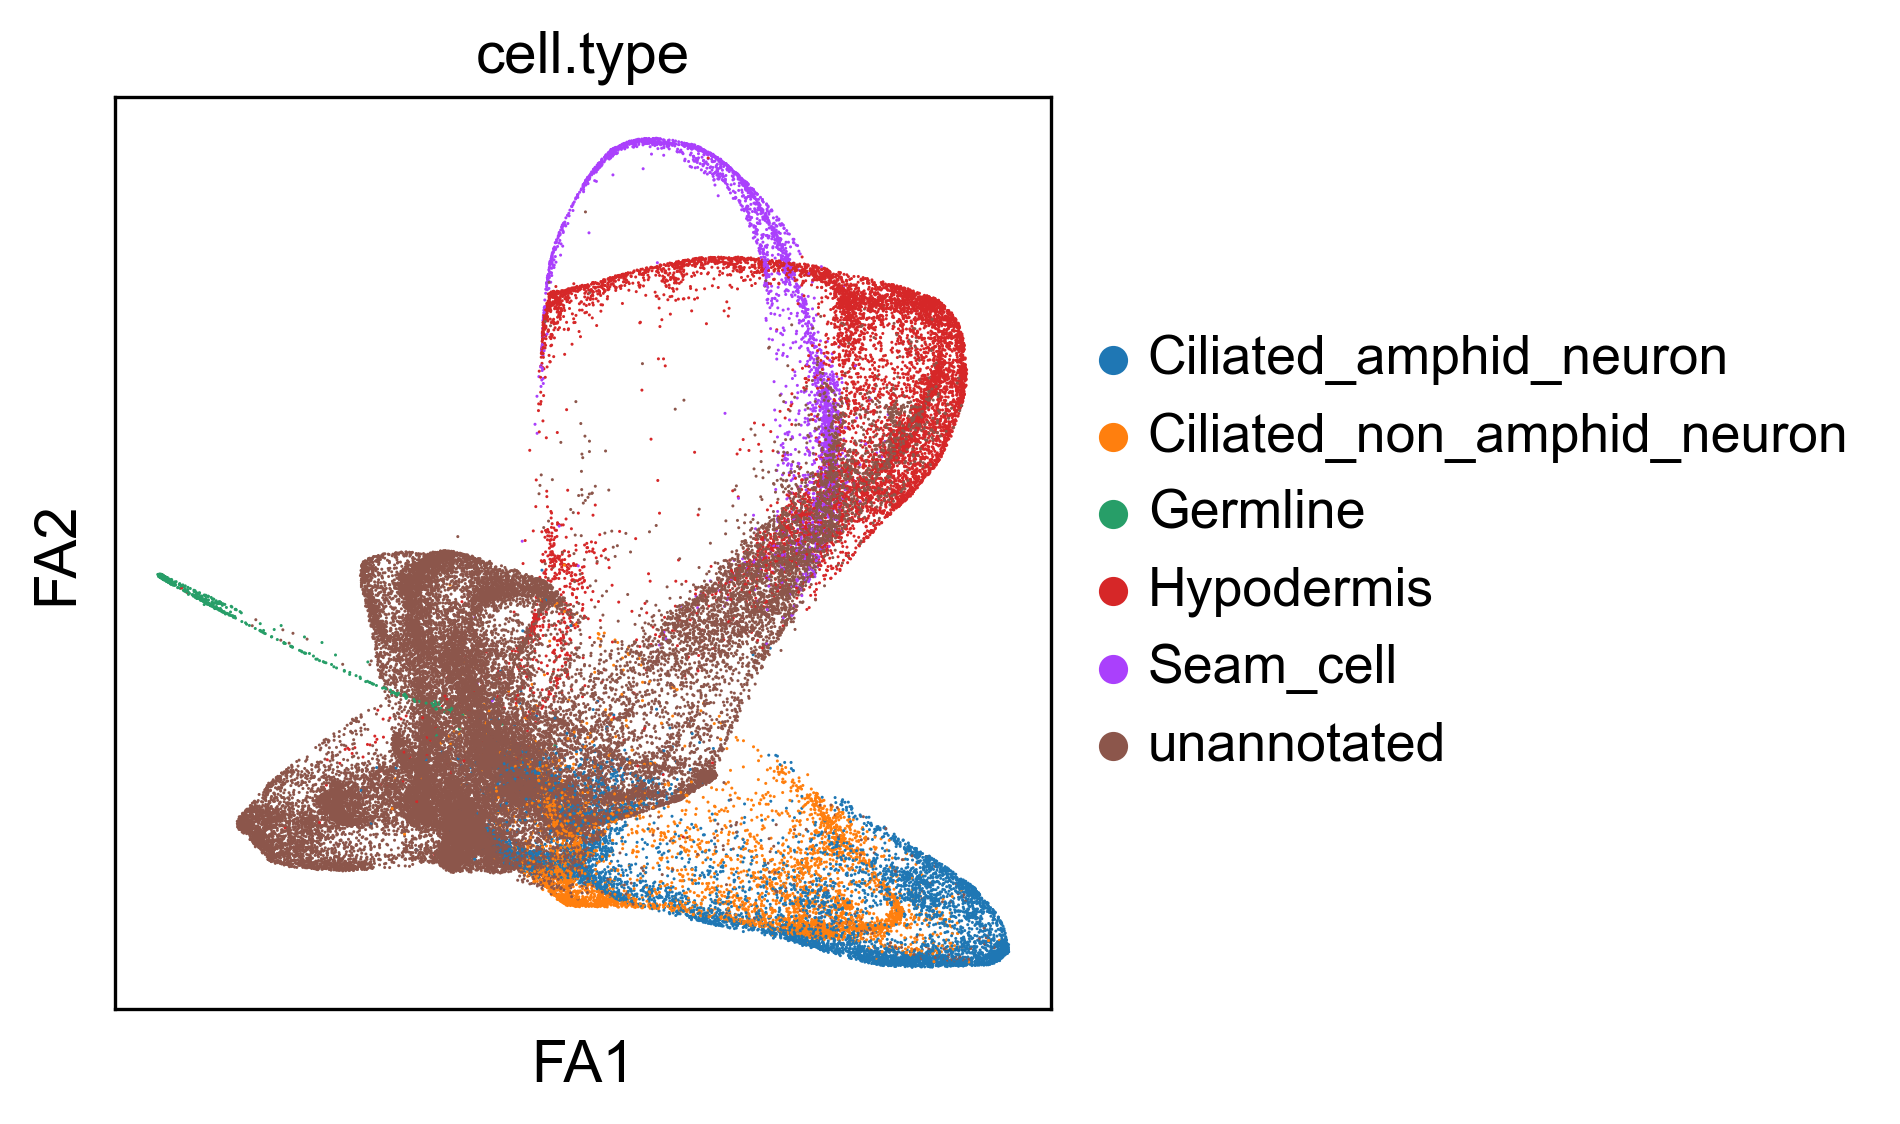

In [31]:
sc.pl.draw_graph(adata,color='cell.type')

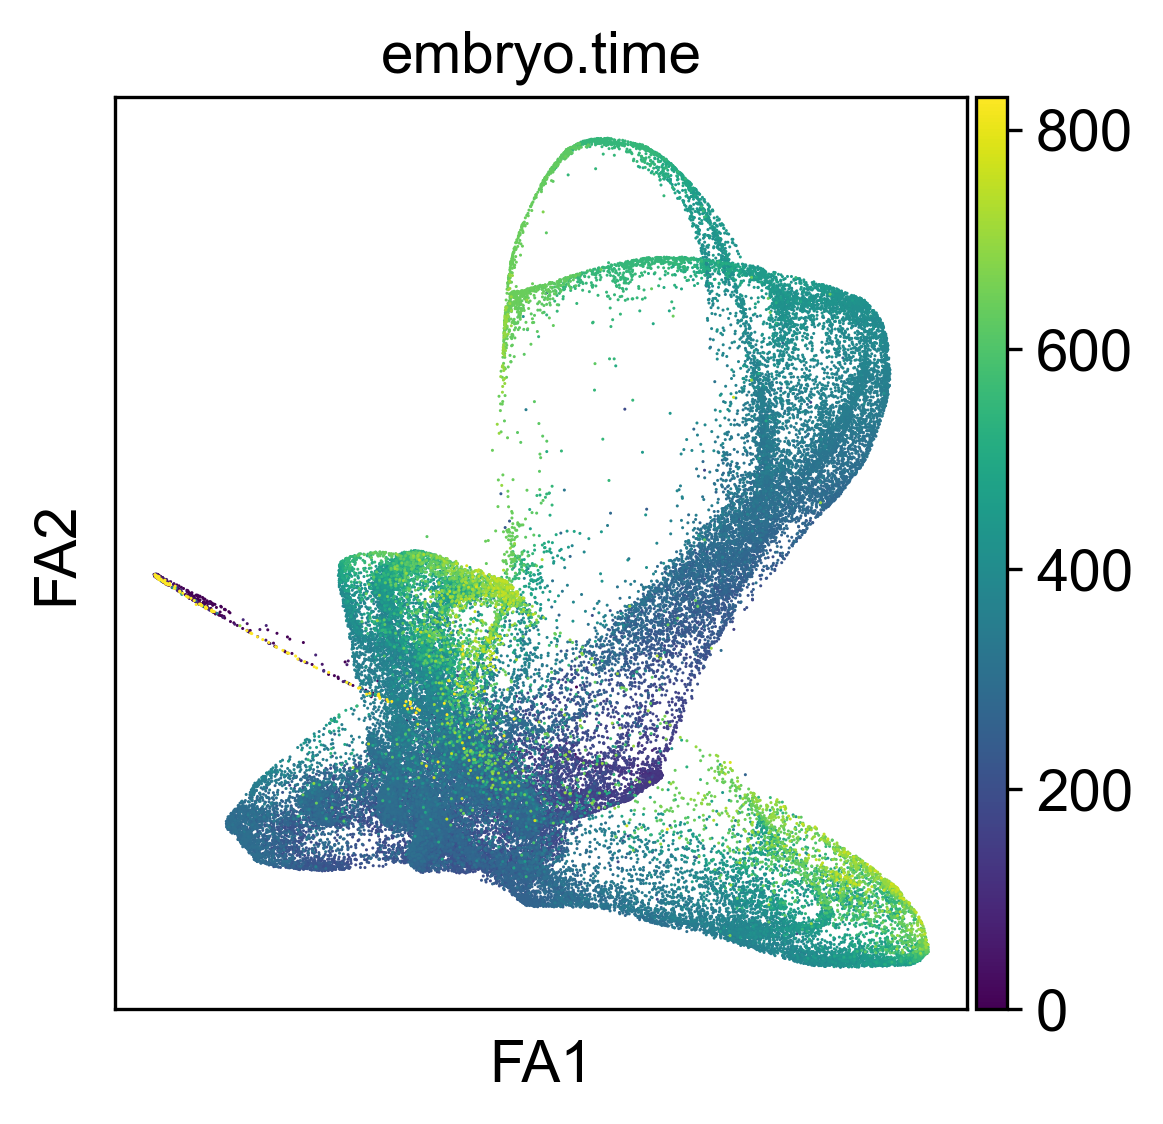

In [32]:
sc.pl.draw_graph(adata,color='embryo.time')

In [35]:
import scFates as scf
scf.pp.diffusion(adata)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


Running Diffusion maps 
Determing nearest neighbor graph...
    determining multiscale diffusion space
    finished (0:00:20) --> added 
    .obsm['X_diffusion_multiscale'], multiscale diffusion space.


In [41]:
sc.pp.neighbors(adata,n_neighbors=100,use_rep="X_diffusion_multiscale",method="rapids")

TypeError: Data type conversion would lose information.

In [44]:
sc.tl.draw_graph(adata,method="rapids",init_pos="X_pca")

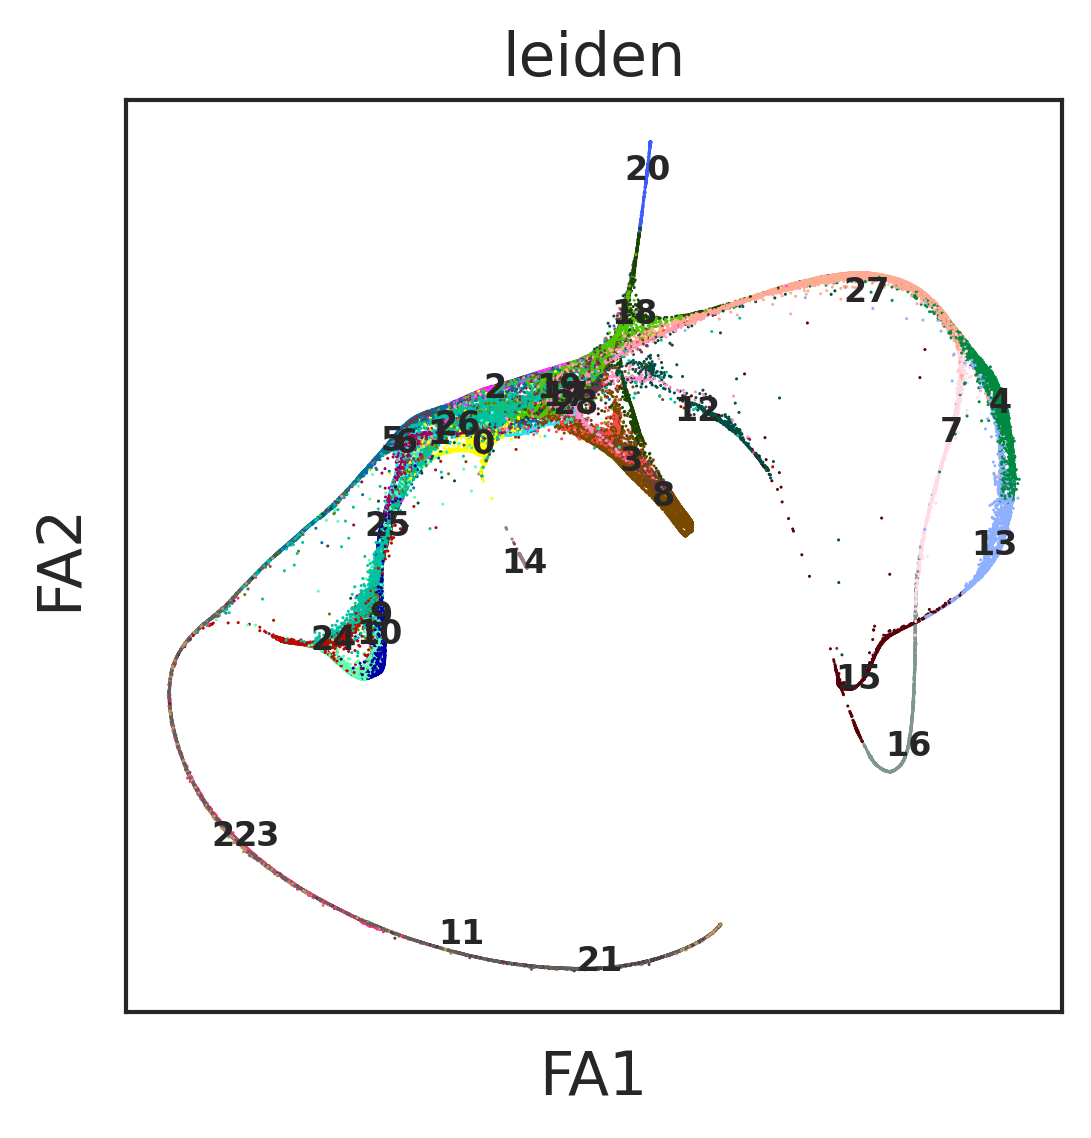

In [45]:
sc.pl.draw_graph(adata,color='leiden',legend_loc='on data',legend_fontsize=8)

/home/lfaure/tools/scanpy/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


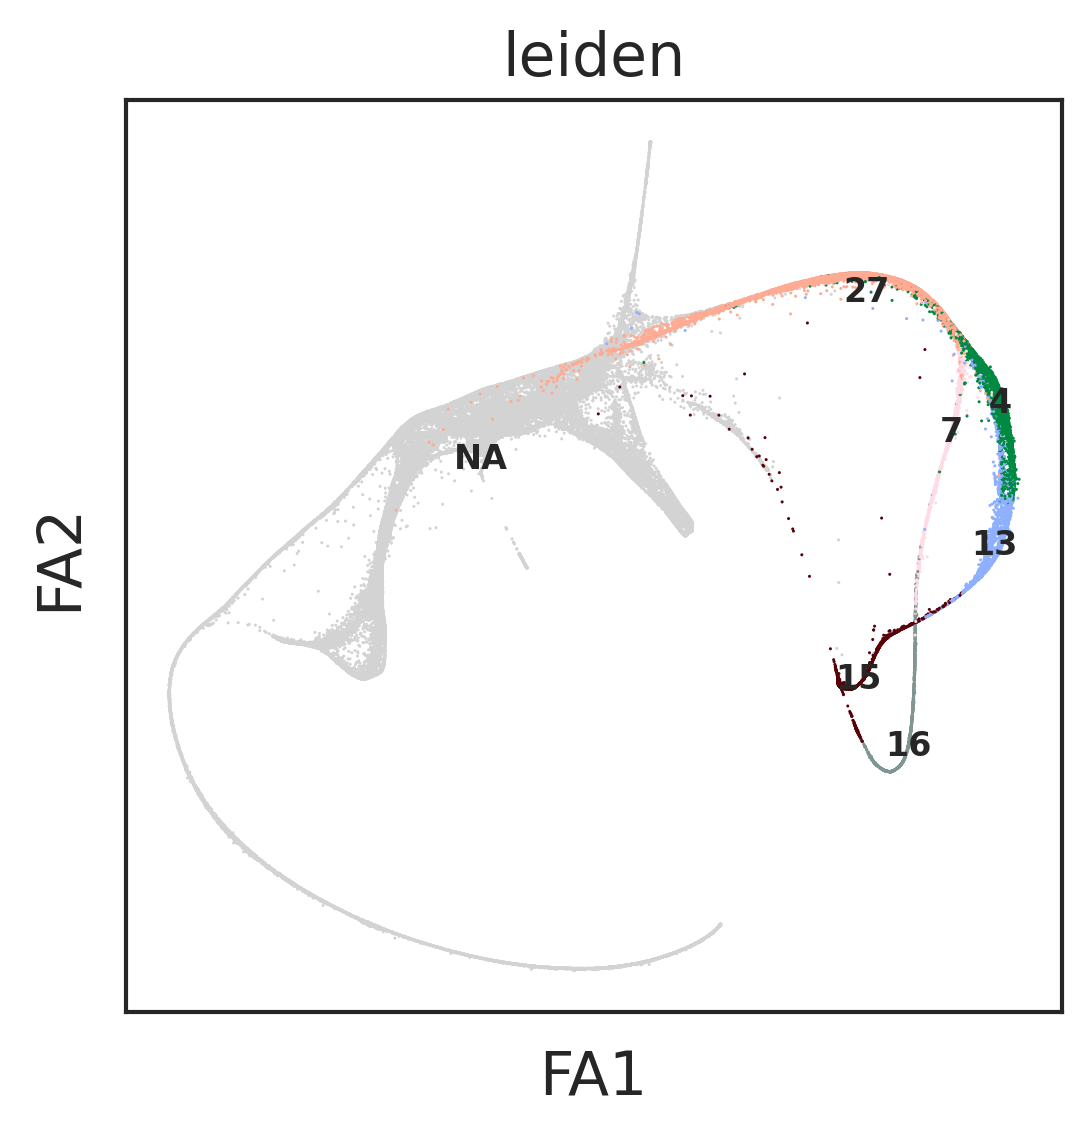

In [56]:
sc.pl.draw_graph(adata,color='leiden',legend_loc='on data',legend_fontsize=8,groups=["27","7","4","13","15","16"])

In [57]:
adata=adata[adata.obs.leiden.isin(["27","7","4","13","15","16"])]

In [63]:
adata.raw.to_adata()

AnnData object with n_obs × n_vars = 14393 × 20222
    obs: 'Cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'to.filter', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'Cluster', 'n_genes_by_counts', 'total_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'draw_graph', 'cell.type_colors', 'graph', 'ppt'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_diffusion_multiscale', 'X_R'
    obsp: 'distances', 'connectivities'

In [64]:
adata.write("adata_preprocess.h5ad")